In [1]:
import pyodbc
from meyerDB import cable_connection
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeavePOut
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
import sklearn.preprocessing as pp
from sklearn.utils import shuffle
from scipy.optimize import curve_fit

from keras import models
from keras.layers import Dense, Dropout


def logifunc(x,x0,k,l):
    #l = 2300
    return l / (1 + np.exp(-k*(x - x0)))


# init db connection
conn = pyodbc.connect(cable_connection)
cursor = conn.cursor()
print('Database connection ok')

def display_table(data):
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            try:
                value = str(round(100*field, 1)).replace('.', ',') + '%'
            except:
                value = field
            html += "<td><h4>%s</h4><td>"%(value)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

Database connection ok


NameError: name 'x0hat' is not defined

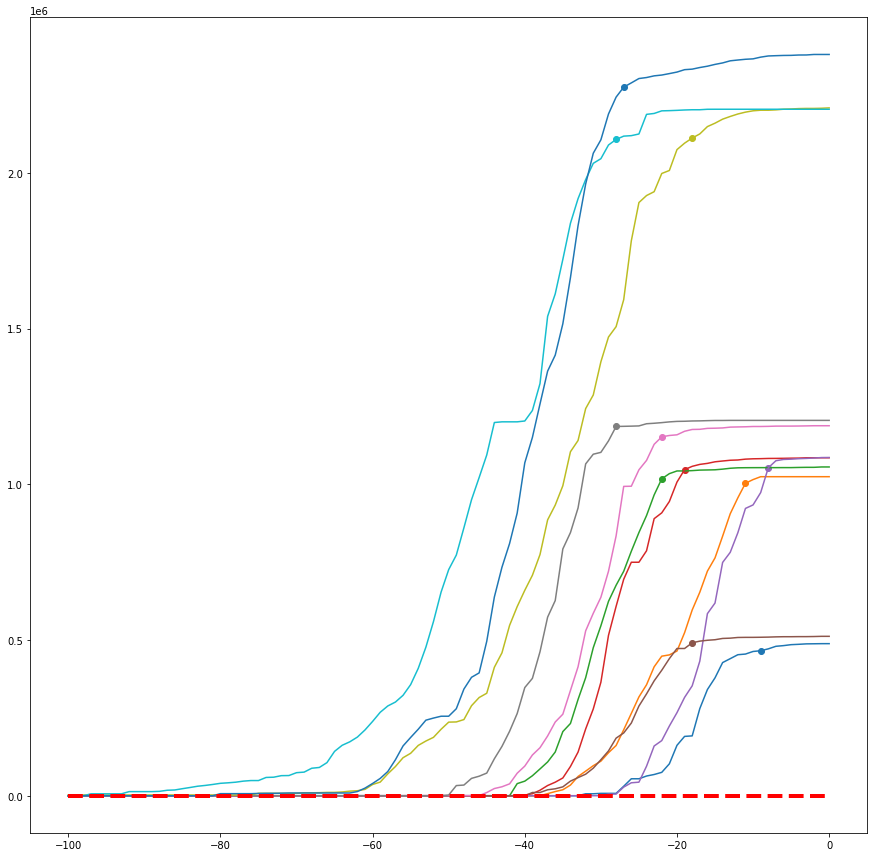

In [7]:
cursor.execute("UPDATE progress SET cables=0")
cursor.execute(
    "UPDATE progress SET progress.cables=t1.cables FROM"
    " (SELECT project_id, rw, sum(amount) as cables FROM ship_readiness GROUP BY project_id, rw) t1"
    " WHERE t1.project_id=progress.project_id AND t1.rw=progress.wk"
)
cursor.commit()


cursor.execute("SELECT project_id FROM routed GROUP BY project_id")
data = np.array(cursor.fetchall())[:, 0]
legends = []
plt.figure(figsize=(15, 15))
all = []
for ship in data:
    #if ship != 1384: continue
    cursor.execute("SELECT wk, cables FROM progress WHERE project_id={} order by wk".format(ship))
    data = np.array(cursor.fetchall())
    x = data[:, 0]
    y = data[:, -1]
    legends.append(ship)
    ycum = y.cumsum()
    ycum_n = ycum/ycum.max(axis=0)
    #(x0hat, khat, lhat), _ = curve_fit(logifunc, x, ycum, bounds=([-100, 0, 1], [0, 10, ycum[-1]*2]))
    x2 = range(-100, 0)
    #yhat = logifunc(x2, x0hat, khat, lhat)
    if False:
        c = -40
        e = -25
        xx = x[c:e]
        yy = ycum[c:e]
        fit = np.polyfit(xx, yy, 2)
        (x0hat, khat, lhat), _ = curve_fit(logifunc, xx, yy, bounds=([-80, 0.0001, ycum[-1]*0.7], [0, 2, ycum[-1]*1.3]))

    all.append(ycum_n)
    plt.plot(x, ycum)
    pp = np.min(np.argwhere(ycum > (0.95*ycum[-1])))
    plt.scatter(x[pp], ycum[pp])
    #plt.plot(x2, yhat)
all = np.array(all)
ycum_n_mean = all.mean(axis=0)
legends.append('mean')
plt.plot(x, ycum_n_mean, 'r--', linewidth=4)
xx = np.linspace(-80, 0, 100)
plt.plot(xx, logifunc(xx, x0hat, khat, lhat), 'g--', linewidth=4)
plt.scatter(e, np.poly1d(fit)(e), c='r')
plt.scatter(c, np.poly1d(fit)(c), c='r')
plt.title("Cable design progress")
plt.xlabel("Weeks to delivery")
plt.ylabel("Cables designed (m)")
plt.legend(legends)
plt.savefig('cumul_progress.png')
plt.show()

In [ ]:
# Get the data
cursor.execute("SELECT r.project_id, gross_tonnage, sum(amount) FROM routed as r"
    " LEFT JOIN projects as p ON p.project_id=r.project_id WHERE r.project_id<>1392"
    " GROUP BY r.project_id, gross_tonnage")
data = np.array(cursor.fetchall()).astype('float32')
ships = data[:, 0]
gt = data[:, 1]
y = data[:, -1]


# update temporary cable counts
cursor.execute("UPDATE progress SET cables=0")
cursor.execute(
    "UPDATE progress SET progress.cables=t1.cables FROM"
    " (SELECT project_id, pw, sum(amount) as cables FROM ship_readiness GROUP BY project_id, pw) t1"
    " WHERE t1.project_id=progress.project_id AND t1.pw=progress.wk"
)
cursor.commit()

linearModel = linear_model.LinearRegression()


p = 2 #ships
lpo = LeavePOut(p)


# train and evaluate
accuracies = []
accuracies2 = []
r = 0
start = -2
wk_range = 1
scale_range = 0.15
min_wk_window = 40
max_wk_window = 101
for train_i, test_i in lpo.split(ships):
    r+=1
    if r < 30:
        continue
    linearModel.fit(gt[train_i].reshape(-1, 1), y[train_i])
    # train
    all = []
    for ship in ships[train_i]:
        cursor.execute("SELECT wk, cables FROM progress WHERE project_id={} ORDER BY wk".format(ship))
        data = np.array(cursor.fetchall())
        xx = data[:, 0]
        yy = data[:, -1]
        ycum = yy.cumsum()
        ycum_n = ycum/ycum.max(axis=0)
        all.append(ycum_n)
        #plt.plot(x, ycum_n)
    all = np.array(all)
    ycum_n_mean = all.mean(axis=0)
    for i in test_i:
        ship = ships[i]
        print(gt[i])
        linear_pred = linearModel.predict([[gt[i]]])[0]
        print(linear_pred)
        step = 5
        for wk in range(start, 1, step):
            cursor.execute(
                "SELECT wk, cables FROM progress WHERE"
                " wk <= {} AND project_id={} ORDER BY wk"
                .format(wk, ship)
            )
            data = np.array(cursor.fetchall())
            wks = data.shape[0]
            xwk = data[:, 0]
            sequence = data[:, -1]/linear_pred
            sequence = sequence.cumsum()
            ses = []
            # from start to current week
            a = wks - min_wk_window
            b = max_wk_window - wks
            errors = []
            for w in range(-a, b, 1):
                if w < 0:
                    shifted_y = sequence[-w:]
                    shifted_x = xwk[-w:] + w
                    cut_y = ycum_n_mean[:shifted_y.shape[0]]
                    cut_x = xx[:shifted_y.shape[0]]
                elif w > 0:
                    shifted_y = np.pad(sequence, (w, 0), 'constant', constant_values=0)
                    end = xwk[0]-w
                    shifted_x = np.pad(xwk, (w, 0), 'linear_ramp', end_values=end)
                    shifted_x += w
                    cut_y = ycum_n_mean[:shifted_y.shape[0]]
                    cut_x = xx[:shifted_y.shape[0]]
                else:
                    shifted_y = sequence
                    shifted_x = xwk
                    cut_y = ycum_n_mean[:shifted_y.shape[0]]
                    cut_x = xx[:shifted_y.shape[0]]
                for s in range(100-int(scale_range*100), 100+int(scale_range*100), 1):
                    scaled_shifted_y = shifted_y*(s/100)
                    c1, c2 = scaled_shifted_y, cut_y
                    ci = np.argmax(c1>0.7)
                    ti = np.argmax(c2>0.7)
                    if scaled_shifted_y[-1] <= 0.7:
                        continue
                    if ci < ti:
                        ci = ti
                    c1 = c1[ci:]
                    c2 = c2[ci:]
                    er = abs(c1-c2)**2/c2**2
                    er_avg = er.mean()
                    row = [er_avg, scaled_shifted_y, shifted_x]
                    errors.append(row)
                    continue
                    if w==0:
                        plt.plot(shifted_x, scaled_shifted_y, linewidth=5)
                    else:
                        plt.plot(shifted_x, scaled_shifted_y)
            errors = np.array(errors)
            best = np.argmin(errors[:, 0])
            [er, scaler, week] = errors[best]

            plt.plot(xx, ycum_n_mean, 'b')
            plt.plot(week, scaler, 'r')
            plt.plot()
            plt.show()
            input('pause')
            


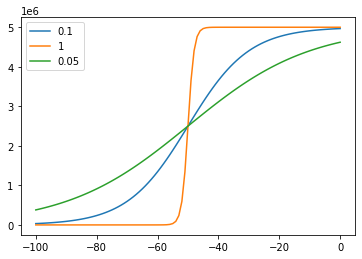

In [5]:
x = np.linspace(-100, 0, 101)
x0 = -50
kk = [0.1, 1, 0.05]
l = 5000000
for k in kk:
    plt.plot(x, logifunc(x, x0, k, l, 1))
plt.legend(kk)
plt.show()

In [ ]:

# Get the data
cursor.execute("SELECT r.project_id, gross_tonnage, sum(amount) FROM routed as r"
    " LEFT JOIN projects as p ON p.project_id=r.project_id WHERE r.project_id=1392"
    " GROUP BY r.project_id, gross_tonnage")
data = np.array(cursor.fetchall()).astype('float32')
ships = data[:, 0]

cursor.commit()


for ship in ships:
    print(ship)
    cursor.execute("SELECT ready FROM routed WHERE project_id={} AND ready IS NOT Null".format(ship))
    dates = []
    for row in cursor.fetchall():
        dates.append(str(row[0]).split(" ")[0])
    cursor.execute("SELECT cable FROM routed WHERE project_id={} AND ready IS Null AND running LIKE 'A%'".format(ship))
    cables = []
    for row in cursor.fetchall():
        cables.append(str(row[0]))
    for cable in cables:
        date = np.random.choice(dates)
        cursor.execute(
            "UPDATE routed SET ready='{}' WHERE project_id={} AND cable='{}'".format(date, ship, cable)
            )

    
cursor.commit()




In [ ]:
wk = 'rw'

cursor.execute("UPDATE progress SET cables=0")
cursor.execute(
    "UPDATE progress SET progress.cables=t1.cables FROM"
    " (SELECT project_id, {}, sum(amount) as cables FROM ship_readiness GROUP BY project_id, {}) t1"
    " WHERE t1.project_id=progress.project_id AND t1.{}=progress.wk".format(wk, wk, wk)
)
cursor.commit()

cursor.execute("SELECT routed.project_id, gross_tonnage FROM routed LEFT JOIN projects ON projects.project_id=routed.project_id GROUP BY routed.project_id, gross_tonnage")
data = np.array(cursor.fetchall())
ships = data[:, 0]
gts = data[:, 1]/100000
legends = []
plt.figure(figsize=(15, 15))
all = []
for i in range(ships.shape[0]):
    ship = ships[i]
    gt = gts[i]

    cursor.execute("SELECT wk, cables FROM progress WHERE project_id={} order by wk".format(ship))
    data = np.array(cursor.fetchall())
    x = data[:, 0]/gt
    y = data[:, -1]/gt
    legends.append(ship)
    ycum = y
    ycum_n = ycum/ycum.sum(axis=0)
    #(x0hat, khat, lhat), _ = curve_fit(logifunc, x, ycum, bounds=([-100, 0, 1], [0, 10, ycum[-1]*2]))
    x2 = range(-100, 0)
    #yhat = logifunc(x2, x0hat, khat, lhat)

    all.append(ycum_n)
    plt.figure()
    plt.plot(x, ycum)
    #plt.scatter(x[pp], ycum[pp])
    #plt.plot(x2, yhat)
all = np.array(all)
plt.xlim([-100, 0])
#xx = np.linspace(-100, 1, 101)
#plt.plot(xx, logifunc(xx, x0hat, khat, lhat), 'g--', linewidth=4)

plt.title("Cable design progress")
plt.xlabel("Weeks to delivery")
plt.ylabel("Cables designed (m)")
plt.legend(legends)
#plt.savefig('cumul_progress.png')
plt.show()

In [ ]:
import pymc3 as pm
from matplotlib import pyplot as plt
import numpy as np



#data generation
def logistic(x, beta):
    return 1.0 / (1.0 + np.exp(beta * x))

#hidden
beta = -5

x = np.linspace(-4, 4, 600)
data = logistic(x, -5)

plt.plot(x,data)

plt.show()

basic_model = pm.Model()

with basic_model:

    def logistic(x=x, beta=beta):
        return 1.0 / (1. + np.exp(beta * x))
    # Priors for unknown model parameters
    beta = pm.Normal("beta", mu=0, sigma=10)
    sig = pm.Normal("sig", mu=0, sigma=10, shape=2)



    #likelihood
    y = pm.Normal("obs", mu=logistic(x, beta), sigma=sig, observed=True)



[-3.02144726e+02  1.55817542e-02  1.00100000e+00]


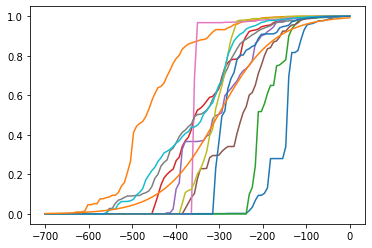

In [4]:
# Dynamic whole ship cable quantities
# Predictors:
# Current quantity, drawings
# Algorithms:
# average drawing cables


def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
def logifunc(x,x0,k,l):
    return l / (1 + np.exp(-k*(x - x0)))

# Get the data
cursor.execute("SELECT r.project_id, gross_tonnage, prototype, ship_squares, sum(amount) FROM routed as r"
    " LEFT JOIN projects as p ON p.project_id=r.project_id"
    " LEFT JOIN (SELECT project_id, sum(squares) as ship_squares FROM areas GROUP BY project_id) as a ON r.project_id=a.project_id"
    " GROUP BY r.project_id, gross_tonnage, prototype, ship_squares")
data = np.array(cursor.fetchall()).astype('int32')
ships = data[:, 0]
gt = data[:, 1]
y = data[:, -1]

# init lpo split
p = 1 #ships
lpo = LeavePOut(p)

# update temporary cable counts
cursor.execute("UPDATE progress SET cables=0")
cursor.execute(
    "UPDATE progress SET progress.cables=t1.cables FROM"
    " (SELECT project_id, pw, count(amount) as cables FROM ship_readiness GROUP BY project_id, pw) t1"
    " WHERE t1.project_id=progress.project_id AND t1.pw=progress.wk"
)
cursor.commit()

model = linear_model.LinearRegression()
ship_data = {}
allx = np.array([])
ally = np.array([])
for ship in ships:
    pred_ends = []
    progresses = []
    start = -100
    step = 1
    for wk in range(start, 1, step):
        # train the model
        cursor.execute(
            "SELECT wk, cables FROM progress WHERE"
            " wk <= {} AND project_id={} ORDER BY wk"
            .format(wk, ship)
        )
        data = np.array(cursor.fetchall())
        sequence = data[:, -1]
        progresses.append((wk, sequence.sum()))
    progresses = np.array(progresses)
    ship_data[ship] = progresses
    x = progresses[:, 0]*7
    y = progresses[:, -1]
    #(x0, k,l, A), _ = curve_fit(logifunc, x, y/y[-1], bounds=([-100, 1e-3, 0.999, 1e-4], [0, 2, 1.001, 100]))
    #x = np.linspace(-60, 60, 200)¬
    #plt.plot(x, logifunc(x, 0, k,l, A))
    plt.plot(x, y/y[-1])
    allx = np.hstack((allx, x))
    ally = np.hstack((ally, y/y[-1]))
params, _ = curve_fit(logifunc, allx, ally, bounds=([-100*7, 1e-3, 0.999], [0, 2, 1.001]))
x = np.linspace(-100*7, 0, 100)
plt.plot(x, logifunc(x, *params))
print(params)
#plt.legend(ships)


#np.save('progress.npy', ship_data)

(465,)


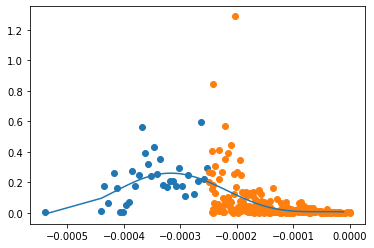

In [ ]:

# Gaussian process regression
# testing
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RBF2, WhiteKernel, ConstantKernel, RationalQuadratic


def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def calc_error():

    res = y_mean[xidxs_inv] - y[xidxs_inv]
    err = abs(res).sum()/(y[xidxs_inv]).sum()
    return err
    
def pplot():
    plt.plot(x[xidxs], y[xidxs]*cables[i], 'g')
    plt.plot(x[xidxs_inv], y[xidxs_inv]*cables[i], 'r')
    plt.plot(x[xidxs_inv], y_mean[xidxs_inv], 'b--')
    plt.ylim([0, 5e6])
    plt.xlim([-100, 0])
    plt.pause(0.17)
    plt.cla()

# Get the data
cursor.execute("SELECT r.project_id, gross_tonnage, sum(amount) FROM routed as r"
    " LEFT JOIN projects as p ON p.project_id=r.project_id"
    " GROUP BY r.project_id, gross_tonnage")
data = np.array(cursor.fetchall())
ships = data[:, 0]
gts = data[:, 1]
cables = data[:, -1]
# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

#init linear pred
model = linear_model.LinearRegression()

wk = 'pw'
cursor.execute("UPDATE progress SET cables=0")
cursor.execute(

    "UPDATE progress SET progress.cables=t1.cables FROM"
    " (SELECT project_id, {}, sum(amount) as cables FROM ship_readiness GROUP BY project_id, {}) t1"
    " WHERE t1.project_id=progress.project_id AND t1.{}=progress.wk".format(wk, wk, wk)
)
cursor.commit()

# get progress data
ship_data = {}
for i in range(ships.shape[0]):
    ship = ships[i]
    cursor.execute("SELECT wk, cables FROM progress WHERE project_id={} and cables > 100 ORDER BY wk".format(ship))
    data = cursor.fetchall()
    ship_data[ship] = np.array(data)/gts[i]



# init gaussian process regressor
kernel = ConstantKernel(constant_value=0.1, constant_value_bounds='fixed') * RBF(
    length_scale=0.0001, length_scale_bounds='fixed')
gp = GaussianProcessRegressor(kernel=kernel,
                            alpha=0.1)

errors = []
completeness = []
prior_x = []
prior_y = []
for i in range(11):
    ship = ships[i]
    if ship == 1396: continue
    prior_x.append(ship_data[ship][:, 0])
    prior_y.append(ship_data[ship][:, 1])
prior_y = np.concatenate(prior_y, axis=0)
prior_x = np.concatenate(prior_x, axis=0)
print(prior_x.shape)
cut = -0.00025
idxs = np.argwhere(x <= cut)[:, 0]
prior_idxs = np.argwhere(prior_x > cut)[:, 0]

x = ship_data[1396][:, 0]
y = ship_data[1396][:, 1]


px = np.hstack((x[idxs], prior_x[prior_idxs]))
py = np.hstack((y[idxs], prior_y[prior_idxs]))
plt.scatter(x[idxs], y[idxs])
plt.scatter(prior_x[prior_idxs], prior_y[prior_idxs])

gp.fit(px.reshape(-1, 1), py.reshape(-1, 1))
y_mean, y_cov = gp.predict(x.reshape(-1, 1), return_cov=True)
plt.plot(x, y_mean)


#X = np.hstack((np.repeat(x, r), prior_x))
#Y = np.hstack((np.repeat(y, r), prior_y))
#gp.fit(X.reshape(-1, 1), Y.reshape(-1, 1))
#y_mean, y_cov = gp.predict(x.reshape(-1, 1), return_cov=True)





In [ ]:
import imageio
images = []
for i in range(30, 100):
    images.append(imageio.imread('progress/{}.png'.format(i)))
imageio.mimsave('movie.gif', images)

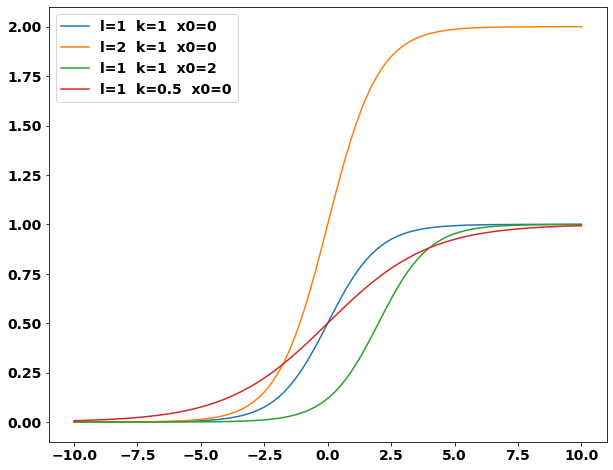

In [8]:
import numpy as np
import matplotlib.pyplot as plt 

plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 'bold'
plt.rcParams["legend.loc"] = 'upper right'

x = np.linspace(-10, 10, 100)
legends = []

plt.figure(figsize=(10, 8))

l, k, x0 = 1, 1, 0
plt.plot(x, l/(1+np.exp(-k*(x-x0))))
legends.append('l={}  k={}  x0={}'.format(l, k, x0))
l, k, x0 = 2, 1, 0
plt.plot(x, l/(1+np.exp(-k*(x-x0))))
legends.append('l={}  k={}  x0={}'.format(l, k, x0))
l, k, x0 = 1, 1, 2
plt.plot(x, l/(1+np.exp(-k*(x-x0))))
legends.append('l={}  k={}  x0={}'.format(l, k, x0))
l, k, x0 = 1, 0.5, 0
plt.plot(x, l/(1+np.exp(-k*(x-x0))))
legends.append('l={}  k={}  x0={}'.format(l, k, x0))
plt.legend(legends, loc='upper left')
plt.savefig('logistic.png')
